# Problem Set 3, due Wednesday, May 3rd, 5:30pm.

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).  The data
(progresa_sample.csv.gz) is available on canvas
in files/data.

Please read the paper to familiarize yourself with
the PROGRESA program before beginning this problem set, so you have a
rough sense of where the data come from and how they were
generated. If you just proceed into the problem set without
understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from
Canvas. The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import sys; print(sys.version)

3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
data = pd.read_csv('/Users/manasi/Desktop/progresa_sample.csv')

In [3]:
data.shape

(77250, 21)

In [4]:
#Analyzing the columns of the data to get an idea of the variables
data.columns

Index(['year', 'sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist',
       'dist_cap', 'poor', 'progresa', 'hohedu', 'hohwag', 'welfare_index',
       'hohsex', 'hohage', 'age', 'village', 'folnum', 'grc97', 'sc97'],
      dtype='object')

In [5]:
print(data.year.unique())
print(data.poor.unique())
print(data.progresa.unique())

[97 98]
['pobre' 'no pobre']
['0' 'basal']


In [6]:
#Converting the variables to boolean values. Using loc to replace them based on value based indexing.
data.loc[data.poor=='pobre','poor']=1
data.loc[data.poor=='no pobre','poor']=0
data.loc[data.progresa=='basal','progresa']=1
data.loc[data.progresa=='0','progresa']=0

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  Present the actual levels for 'progresa' and
'poor'.  Do these fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [7]:
#Making a series x by eliminating the year,folnum and village rows. Removing all the other summary statistics
#except for mean and SD. Making another series that take in the number of null values
#Concatenating both the series
x=data[data.columns.difference(['year','folnum','village'])].describe()
x = x.loc['mean':'std',:]
x=x.T
y=data.isnull().sum()
y=y.drop(['year','folnum','village'])
y=y.sort_index(axis=0, level=None, ascending=True, inplace=False, sort_remaining=True)
new = pd.concat([x, y], axis=1)
new

,mean,std,0
age,11.366460,3.167744,0
dist_cap,147.674452,76.063134,0
dist_sec,2.418910,2.234109,0
fam_n,7.215715,2.352900,0
grc,3.963537,2.499063,6549
grc97,3.705372,2.572387,0
hohage,44.436717,11.620372,10
hohedu,2.768104,2.656106,0
hohsex,0.925185,0.263095,20
hohwag,586.985312,788.133664,0


In [8]:
data.describe()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
count,77250.000000,77226.000000,76950.000000,77250.000000,68797.000000,70701.000000,77250.000000,77250.000000,77250.000000,77250.000000,77250.000000,77040.000000,77230.000000,77240.000000,77250.000000,77250.000000,77250.000000,77250.000000,73378.000000
mean,97.500000,0.512211,0.298324,2.418910,0.819818,3.963537,7.215715,103.447520,147.674452,2.768104,586.985312,690.346564,0.925185,44.436717,11.366460,253.614964,19313.000000,3.705372,0.813922
std,0.500003,0.499854,0.457525,2.234109,0.384342,2.499063,2.352900,42.089441,76.063134,2.656106,788.133664,139.491130,0.263095,11.620372,3.167744,149.341967,11150.149239,2.572387,0.389172
min,97.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.465392,9.465392,0.000000,0.000000,180.000000,0.000000,15.000000,6.000000,1.000000,1.000000,0.000000,0.000000
25%,97.000000,0.000000,0.000000,0.574000,1.000000,2.000000,6.000000,70.518238,92.327050,0.000000,120.000000,597.000000,1.000000,36.000000,9.000000,126.000000,9657.000000,1.000000,1.000000
50%,97.500000,1.000000,0.000000,2.279000,1.000000,4.000000,7.000000,111.228612,132.001494,2.000000,500.000000,685.000000,1.000000,43.000000,11.000000,257.000000,19313.000000,4.000000,1.000000
75%,98.000000,1.000000,1.000000,3.582000,1.000000,6.000000,9.000000,138.446009,184.445225,4.000000,750.000000,770.000000,1.000000,51.000000,14.000000,385.000000,28969.000000,6.000000,1.000000
max,98.000000,1.000000,1.000000,14.879000,1.000000,14.000000,24.000000,170.457647,359.774457,20.000000,14000.000000,1294.000000,1.000000,98.000000,17.000000,505.000000,38625.000000,14.000000,1.000000


### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [70]:
poor_97 = data[(data.poor==1)&(data.year==97)]
#Creating separate treatment and control groups
treatment_group=poor_97.loc[poor_97.progresa==1]
control_group=poor_97.loc[poor_97.progresa==0]

In [72]:
#Calculating average values for all variables in Control and Treatment groups
x=treatment_group[treatment_group.columns.difference(['year','folnum','village'])].describe()
treatment_average=x.loc['mean']
y=control_group[control_group.columns.difference(['year','folnum','village'])].describe()
control_average=y.loc['mean']

In [73]:
#Based on the above created two groups, we create a dataframe that contains the index and the values for both the treatment and the control group.
df1 = pd.DataFrame({'Variable name':treatment_average.index, 'Average value (Treatment villages)':treatment_average.values},
                        columns = ['Variable name','Average value (Treatment villages)'])
df2 = pd.DataFrame({'Variable name':control_average.index, 'Average value (Control villages)':control_average.values},
                        columns = ['Variable name','Average value (Control villages)'])


In [74]:
#Merge df1 and df2 on a common condition of the index which is our variable name.
result=pd.merge(df1,df2, on = 'Variable name')
result

,Variable name,Average value (Treatment villages),Average value (Control villages)
0,after,0.000000,0.000000
1,age,10.716991,10.742023
2,dist_cap,150.829074,153.769730
3,dist_sec,2.453122,2.507662
4,fam_n,7.281327,7.302469
5,grc,3.531599,3.543050
6,grc97,3.531599,3.543050
7,hohage,43.640194,44.273369
8,hohedu,2.663139,2.590348
9,hohsex,0.924290,0.922799


In [75]:
#Now that we have to calculate the p value and the t statistic, we fill all the NA's in our treatment and control group by 0
treatment_group=treatment_group.fillna(0)
control_group=control_group.fillna(0)

In [76]:
#Having a clean series in hand, we can now calculate the p and t stat values. 
#Creating an empty dictionary first that will hold the p and t values

p={}
t={}

#Initially creating the first value of the dictionary that includes the pvalue and the t statistic of the first variable
p={'age':ttest_ind(treatment_group.age,control_group.age).pvalue}
t={'age':ttest_ind(treatment_group.age,control_group.age).statistic}

#Updating it with dist_cap
p.update({'dist_cap':ttest_ind(treatment_group.dist_cap,control_group.dist_cap).pvalue})
t.update({'dist_cap':ttest_ind(treatment_group.dist_cap,control_group.dist_cap).statistic})

#Updating it with dist_sec
p.update({'dist_sec':ttest_ind(treatment_group.dist_sec,control_group.dist_sec).pvalue})
t.update({'dist_sec':ttest_ind(treatment_group.dist_sec,control_group.dist_sec).statistic})

#Updating the dictionary with fam_n
p.update({'fam_n':ttest_ind(treatment_group.fam_n,control_group.fam_n).pvalue})
t.update({'fam_n':ttest_ind(treatment_group.fam_n,control_group.fam_n).statistic})

#Updating it with grc
p.update({'grc':ttest_ind(treatment_group.grc,control_group.grc).pvalue})
t.update({'grc':ttest_ind(treatment_group.grc,control_group.grc).statistic})

#Updating it with grc97
p.update({'grc97':ttest_ind(treatment_group.grc97,control_group.grc97).pvalue})
t.update({'grc97':ttest_ind(treatment_group.grc97,control_group.grc97).statistic})

#Updating it with hohage
p.update({'hohage':ttest_ind(treatment_group.hohage,control_group.hohage).pvalue})
t.update({'hohage':ttest_ind(treatment_group.hohage,control_group.hohage).statistic})

# For hohedu hohsex hohwag indig
p.update({'hohsex':ttest_ind(treatment_group.hohsex,control_group.hohsex).pvalue})
t.update({'hohsex':ttest_ind(treatment_group.hohsex,control_group.hohsex).statistic})

p.update({'hohwag':ttest_ind(treatment_group.hohwag,control_group.hohwag).pvalue})
t.update({'hohwag':ttest_ind(treatment_group.hohwag,control_group.hohwag).statistic})

p.update({'indig':ttest_ind(treatment_group.indig,control_group.indig).pvalue})
t.update({'indig':ttest_ind(treatment_group.indig,control_group.indig).statistic})

#min_dist sc sc97 sex welfare_index

p.update({'min_dist':ttest_ind(treatment_group.min_dist,control_group.min_dist).pvalue})
t.update({'min_dist':ttest_ind(treatment_group.min_dist,control_group.min_dist).statistic})

p.update({'sc':ttest_ind(treatment_group.sc,control_group.sc).pvalue})
t.update({'sc':ttest_ind(treatment_group.sc,control_group.sc).statistic})

p.update({'sex':ttest_ind(treatment_group.sex,control_group.sex).pvalue})
t.update({'sex':ttest_ind(treatment_group.sex,control_group.sex).statistic})

p.update({'welfare_index':ttest_ind(treatment_group.welfare_index,control_group.welfare_index).pvalue})
t.update({'welfare_index':ttest_ind(treatment_group.welfare_index,control_group.welfare_index).statistic})

In [77]:
print(p)

{'age': 0.47855944566679565, 'dist_cap': 0.00084150052762919339, 'dist_sec': 0.035698428274042397, 'fam_n': 0.42710393275181735, 'grc': 0.68901509486896795, 'grc97': 0.68901509486896795, 'hohage': 1.5159183684285367e-06, 'hohsex': 0.62177374712809086, 'hohwag': 0.00032538351424080483, 'indig': 0.22559994640948516, 'min_dist': 2.3583122755379036e-16, 'sc': 0.044163796408746993, 'sex': 0.012286550586879538, 'welfare_index': 0.63794347354603598}


In [78]:
#Converting them to dataframes so that we can merge them with the earlier table
df3=pd.DataFrame(list(p.items()), columns=['Variable name','p-value'])
df4=pd.DataFrame(list(t.items()), columns=['Variable name','Difference(Treatment-Control)'])


In [65]:
#Merging the above two dataframes with result
result=pd.merge(result,df4, on = 'Variable name')
result=pd.merge(result,df3, on = 'Variable name')
result

,Variable name,Average value (Treatment villages),Average value (Control villages),Difference(Treatment-Control),p-value
0,age,10.716991,10.742023,-0.708630,4.785594e-01
1,dist_cap,150.829074,153.769730,-3.339081,8.415005e-04
2,dist_sec,2.453122,2.507662,-2.100433,3.569843e-02
3,fam_n,7.281327,7.302469,-0.794167,4.271039e-01
4,grc,3.531599,3.543050,-0.400196,6.890151e-01
5,grc97,3.531599,3.543050,-0.400196,6.890151e-01
6,hohage,43.648828,44.276918,-4.810013,1.515918e-06
7,hohsex,0.924656,0.922947,0.493343,6.217737e-01
8,hohwag,544.339544,573.163558,-3.594588,3.253835e-04
9,indig,0.325986,0.332207,-1.211794,2.255999e-01


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

A) To be statistically significant, the groups cannot be explained by chance and there has to be another parameter that justifies this significance. Usually, statistical significance is determined when the p value is less than 0.05. Here we see that the fourth column for Difference(Treatment-Control) is significant for variables dist_cap, dist_sec, hohage, hohedu, hohwag, min_dist, sc and sex. This can be confirmed with the p value which is less than 0.05 in the variables mentioned. Hence, there are statistically significant differences between control and treatment village baseline as majority variables tend to be in that criteria.

B) The main purpose in creating an experiment is that, factually it is impossible to conduct an experiement on the entire population. In such cases, to determine the conclusion of an experiment we take two samples from the population and they are distributied randomly. This process is called randomization. The main purpose in doing randomization is that the parameters of the population are similar so that fair experiments can be carried out. Here, as we see, from our p values and t test that there is a statistical difference between the variables. Differences at baseline indicate that the process of randomization that aims to make the treatment and control groups similar in all aspects except for the variable under study & to understand its causal effects did not succeed completely for all variables. As there is statistically significant difference between the treatment and control group prior to the treatment, the effect of Progresa cannot be clearly determined through the data from the subsequent surveys.

C) We can measure the impact of the treatment by using Double difference as randomization did not give us any similarity between two groups.This is because diff in diff calculates the effect of a treatment on an outcome by comparing the average change over time in the outcome variable for the treatment group, compared to the average change over time for the control group.It is intended to mitigate the effects of extraneous factors and selection bias. 

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

In [17]:
#Just like we subsetted the data above, we subset the progresa data based on the year 97
progresa_97=data[data.year==97]
progresa_97_avg=progresa_97.groupby(['hohedu']).sc.mean()
#We adjust the index here because initially the 'hohedu' column was coming as the index and while plotting it couldnt identify a column
progresa_97_avg = progresa_97_avg.reset_index()
progresa_97_avg

,hohedu,sc
0,0,0.776137
1,1,0.768537
2,2,0.794552
3,3,0.802956
4,4,0.842951
5,5,0.849835
6,6,0.878469
7,7,0.889535
8,8,0.900000
9,9,0.925023


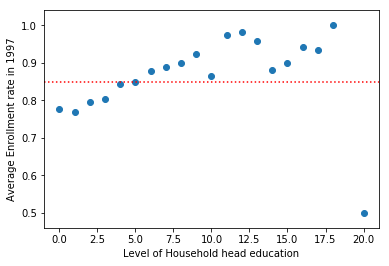

In [18]:
#Plotting the data
fig,ax=plt.subplots()
threshold = 0.85
ax.axhline(y=threshold, color='r', linestyle=':')
plt.scatter(progresa_97_avg.hohedu,progresa_97_avg.sc)
plt.xlabel("Level of Household head education")
plt.ylabel("Average Enrollment rate in 1997")
plt.show()

Observation: 
Here I have considered the threshold to 0.85 just to understand the spread and the distribution of the values.
The average enrollment rate is seen as a steady increase from 0.75 to 9. It drops a little and again rises as a wave. The same pattern of drop and rise is observed for 15 and 17.5. At 20, it drastically drops. This is a bit unusual behavior. I described the data to see that there were only 2 records available with 1 as enrolled.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for
1998. On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

In [30]:
#Subset data
avg_treatment_before = data[(data.poor==1)&(data.progresa==1)&(data.year==97)].groupby(['village']).mean()
avg_treatment_after = data[(data.poor==1)&(data.progresa==1)&(data.year==98)].groupby(['village']).mean()

#Because the village comes as an index, we reset the index
avg_treatment_before=avg_treatment_before.reset_index()
avg_treatment_before=avg_treatment_before.reset_index()


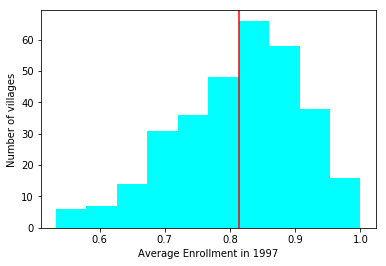

In [32]:
fig = plt.figure()
ax = plt.hist(avg_treatment_before.sc,color="cyan")
plt.ylabel("Number of villages")
plt.xlabel("Average Enrollment in 1997")
plt.axvline(avg_treatment_before.sc.mean(), color='red')
plt.show()

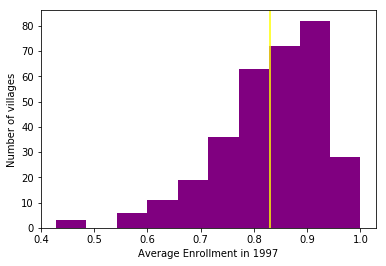

In [33]:
fig = plt.figure()
ax = plt.hist(avg_treatment_after.sc,color="purple")
plt.ylabel("Number of villages")
plt.xlabel("Average Enrollment in 1997")
plt.axvline(avg_treatment_after.sc.mean(), color='yellow')
plt.show()

In [69]:
print (avg_treatment_before.sc.mean())
print (avg_treatment_after.sc.mean())
print(ttest_ind(avg_treatment_after.sc,avg_treatment_before.sc).pvalue)
#t = ttest_ind(avg_treatment_before.sc,avg_treatment_after.sc)


0.8138394110596501
0.8295362042630732
0.0442487003657




Looking at the enrollment rates between pre and post treatment villages among poor households reveals a considerable difference between the means (0.81 vs 0.83), and a statistically significant p value of 0.044. Hence we can say that the enrollment rate changed for poor households in treatment villages between 97 and 98.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [67]:
treatment_group_98=data[(data.poor==1)&(data.progresa==1)&(data.year==98)]
control_group_98=data[(data.poor==1)&(data.progresa==0)&(data.year==98)]

#Printing the average enrollment rate in treatment and control groups for the year 98
print('Average enrollment rate in treatment villages in 98',treatment_group_98.sc.mean())
print('Average enrollment rate in control villages in 98', control_group_98.sc.mean())

#Using the t-test to determine if this difference is statistically significant
#ttest_ind(treatment_group_98.sc,control_group_98.sc)
ttest_ind(treatment_group_98.sc[~np.isnan(treatment_group_98.sc)],control_group_98.sc[~np.isnan(control_group_98.sc)])

Average enrollment rate in treatment villages in 98 0.8464791213954308
Average enrollment rate in control villages in 98 0.807636956730308


Ttest_indResult(statistic=8.3587205674183735, pvalue=6.636344447523235e-17)

The difference here is statistically significant. It can be observed that the average enrollment rate differs marginally. This can be confirmed from the p value as it is less than 0.05.



### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [24]:

progresa_98=data[(data.poor==1)&(data.year==98)]
mod = smf.ols(formula='sc~progresa', data=progresa_98)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Tue, 01 May 2018   Prob (F-statistic):           6.64e-17
Time:                        21:55:07   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8076      0.004    220.676

1. The base coefficient for the enrollment is 0.8076. The value of progresa being true in a tuple increases the enrollment odds by a coefficient of 0.0384. 
2. The regression estimate given to us is 0.8076 which is same as the mean of enrollment in control based villages. The regression increases the likelihood of enrollment by 0.0388 which results in a regression estimate of treatment based villages to 0.8464 which is also same as the mean we found in the previous 2.1 analysis
3. Since the P > |t| value is 0 or both intercept and progresa T, we can say that the p value is less than critical value and we can reject the null hypothesis.
4. The assumption underlying in the regression is that the other factors like sex, household, distance from school and age do not play unequal roles (make uniformly equal comtribution) to both treatment and non treatment cases. 

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [25]:
progresa_98=data[(data.poor==1)&(data.year==98)]
mod = smf.ols(formula='sc~progresa+age+ dist_sec + sex + hohedu + indig + fam_n + min_dist+ hohage + hohedu', data=progresa_98)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     1135.
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        21:55:07   Log-Likelihood:                -7590.0
No. Observations:               27336   AIC:                         1.520e+04
Df Residuals:                   27326   BIC:                         1.528e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4609      0.014    103.413

The controls in the multiple regression model reduced the point estimate of the treatment effect to 0.033 from 0.0388 in the single regression model.

The controls reduced the standard error from 0.005 in the single regression model to 0.004 in the multiple regression model.

Differences(or similarities) in the estimates - a)The intercept has increased from 0.8076 (Single regression model) to 1.4609 (Multiple regression model) which implies that while controlling for multiple factors, the avg. enrollment would have increased considerabely in the absence of the treatment. b)With the controls in the multiple regression model, the R squared value = 0.272, indicating the model explains the variations in the data better than the single regression model. c)In the multiple regression model, it is observed that with an increase in age by 1 year, the avg. enrollment rate reduces by 0.0657 while holding the other factors constant and similarly with an increase in distance to secondary school by 1 unit, the avg. enrollment rate reduces by 0.0114 while holding the other factors constant.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

* What is the counterfactual assumption underlying this estimate? 


In [80]:
#Subsetting data
treatment_97 = data[(data.year==97)&(data.poor==1)&(data.progresa==1)]
treatment_98 = data[(data.year==98)&(data.poor==1)&(data.progresa==1)]
control_97 = data[(data.year==97)&(data.poor==1)&(data.progresa==0)]
control_98 = data[(data.year==98)&(data.poor==1)&(data.progresa==0)]

#Average enrollment rate in each
avg_enroll_treatment_97 = treatment_97.sc.mean()
avg_enroll_treatment_98 = treatment_98.sc.mean()
avg_enroll_control_97 = control_97.sc.mean()
avg_enroll_control_98 = control_98.sc.mean()

dd_df = pd.DataFrame([[avg_enroll_treatment_97,avg_enroll_control_97],[avg_enroll_treatment_98,avg_enroll_control_98]]
                    ,columns = ['Average Enrollment - Treatment Group','Average Enrollment - Control Group']
                    ,index = ['1997 (Before Treatment)','1998 (After Treatment)'])
print ("Difference - in - Difference is: ", (avg_enroll_treatment_98 - avg_enroll_control_98) - (avg_enroll_treatment_97 - avg_enroll_control_97) )
dd_df

Difference - in - Difference is:  0.031331280319323085


,Average Enrollment - Treatment Group,Average Enrollment - Control Group
1997 (Before Treatment),0.822697,0.815186
1998 (After Treatment),0.846479,0.807637


The estimate of the treatment impact is 0.03133. The impact of the treatment is reduced compared to the simple difference result of 0.0388 obtained in the single regression model. As established previously that the randomization process did not obtain ideal results, the difference in difference model is a better estimate of the treatment impact.
The counterfactual assumption is that difference-in-difference value would have been 0, i.e the average enrollment difference between the treatment group and control group would have been the same in 97 and 98, in the absence of the treatment.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.

* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?

* What is the counterfactual assumption underlying this regression? 

In [82]:
#Create variable to identify 97 - before treatment and 98 - after treatment
data.loc[data.year == 97, 'after'] = 0
data.loc[data.year == 98, 'after'] = 1

progresa_97_98_poor = data[((data.after == 1) | (data.after == 0)) & (data.poor == 1)]

double_diff_lm = smf.ols(formula = 'sc ~ progresa + after + progresa:after + age + dist_sec + sex + hohedu + indig + fam_n + min_dist+ hohage + hohedu',
                data=progresa_97_98_poor).fit()
double_diff_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     2081.
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        23:27:10   Log-Likelihood:                -16562.
No. Observations:               58157   AIC:                         3.315e+04
Df Residuals:                   58145   BIC:                         3.326e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4282      0.010    146.029      0.000       1.409       1.447
progresa[T.1]           0.0020      0.004      0.527      0.598      -0.005       0.009
after                   0.0273      0.004      6.279      0.000       0.019       0.036
progresa[T.1]:after     0.0313      0.006      5.692      0.000       0.021       0.042
age                    -0.0658      0.000   -143.647      0.000      -0.067      -0.065
dist_sec               -0.0103      0.001    -16.679      0.000      -0.011      -0.009
sex                     0.0333      0.003     12.456      0.000       0.028       0.038
hohedu                  0.0078      0.001     13.472      0.000       0.007       0.009
indig                   0.0329      0.003     10.899      0.000       0.027       0.039
fam_n                  -0.0002      0.001     -0.365      0.715      -0.001       0.001
min_dist                0.0006   3.39e-05     16.959      0.000       0.001       0.001
hohage                  0.0003      0.000      2.549      0.011    7.65e-05       0.001
==============================================================================
Omnibus:                     5461.777   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7167.479
Skew:                          -0.858   Prob(JB):                         0.00
Kurtosis:                       3.108   Cond. No.                         914.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimate of the impact of Progresa is 0.0313. To obtain this result, the year variable was changed to after = 1 (1998) and after = 0 (1997). It is observed that considering the treatment impact in 1998 is the same as the result obtained in 2.5. There is an increase in average enrollment in the treatment group in 1998 with 0.0313 as the new coefficient while controlling for other variables, with a standard error of 0.006.

The estimates obtained here are lower than the simple difference as it considers the difference in the treatment and control group prior to the treatment. Hence the estimate is more precise.

This estimate is equal to the one obtained in 2.4. A marginal difference in the decimal values can be attributed to the control variables introduced.

The counterfactual assumption is that the difference in difference value would have been 0, i.e the average enrollment difference between the treatment group and control group would have been the same in 97 and 98, in the absence of the treatment.

### 2.6 Summary

* Yes, Progresa did have a causal impact on the enrollment rates of poor households in Mexico. The causal impact is not significant but is definetely observed among treatment groups in the poor households. Additional spill-over effects with an increase in avg. enrollment among non-poor households also shows that the Progresa study is having a positive impact on increasing the overall enrollment rate in the community.

*Discuss your results here*